In [208]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns

In [209]:
df = pd.read_csv('train.csv')

In [210]:
zeros = df[df.label == 0].drop('label', 1)
ones = df[df.label == 1].drop('label', 1) 
twos = df[df.label == 2].drop('label', 1) 
threes = df[df.label == 3].drop('label', 1) 
fours = df[df.label == 4].drop('label', 1) 
fives = df[df.label == 5].drop('label', 1) 
sixs = df[df.label == 6].drop('label', 1) 
sevens = df[df.label == 7].drop('label', 1) 
eights = df[df.label == 8].drop('label', 1) 
nines = df[df.label == 9].drop('label', 1) 

digit_list = [zeros,ones, twos, threes, fours, fives, sixs, sevens, eights, nines]

In [211]:
# for digit in digit_list:
#     sns.heatmap(data=pd.DataFrame(digit.head(1).values.reshape((28,28))))
#     plt.show()

In [212]:
def euclidean_distance(A, B):
    return np.sqrt(np.dot(A-B))

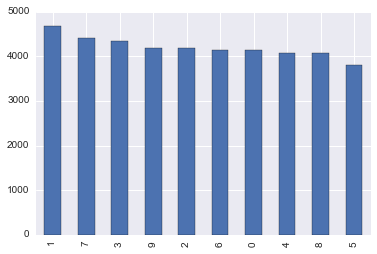

In [213]:
df.sort('label').label.value_counts().plot(kind='bar')

In [214]:
zeros = zeros.reset_index()

In [217]:
A = zeros.loc[1].drop("index").reshape((28,28))
B = zeros.loc[2].drop("index").reshape((28,28))

np.linalg.norm(A-B)


TypeError: Required argument 'b' (pos 2) not found